In [1]:
from urllib.request import urlopen
from PIL import Image
import timm
import torch
import json

# the json file where the output must be stored
json_file = open("imagenet_labels.json", "r")
imagenet_dict = json.load(json_file)
json_file.close()

def predict(model, img):
    output = model(img)
    top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)
    return top5_probabilities, top5_class_indices.tolist()[0]

def preprocess_data(img):
    # unsqueeze single image into batch of 1.
    return transforms(img).unsqueeze(0)

def idx_to_label(idx):
    if isinstance(idx, list):
        return [idx_to_label(i) for i in idx]
    else:
        return imagenet_dict.get(str(idx))

In [2]:
img = Image.open(urlopen(
    'https://unsplash.com/photos/DwxlhTvC16Q/download?ixid=M3wxMjA3fDB8MXxzZWFyY2h8MXx8bWVyY2VkZXMlMjBjYXJ8ZW58MHx8fHwxNjg2NzA1MzUyfDA&force=true&w=640'
))

model = timm.create_model('vgg16.tv_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
# Is this run on GPU??
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

In [26]:
type(transforms)

torchvision.transforms.transforms.Compose

In [3]:
probs, labels = predict(model, preprocess_data(img))
idx_to_label(labels)

['sports car, sport car',
 'racer, race car, racing car',
 'car wheel',
 'convertible',
 'pickup, pickup truck']

In [17]:
from energy_meter import EnergyMeter

# Disk in LSD15 has an avg i/o speed of 1600MB/s and 
# a power consumption of 6W when active and 1.42W when idle.
meter_gpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="GPU Inference")
# BEFORE this line, we should have already started running the bash
# script start_meters.sh.
model.to("cuda:0")
meter_gpu.begin()
for _ in range(100):
    p_img = preprocess_data(img)
    probs, labels = predict(model, p_img.cuda())
meter_gpu.end()

In [16]:
# CPU
meter_cpu = EnergyMeter(disk_avg_speed=1600*1e6, 
                        disk_active_power=6, 
                        disk_idle_power=1.42, 
                        label="CPU Inference")
model.to("cpu")
meter_cpu.begin()
for _ in range(100):
    p_img = preprocess_data(img)
    probs, labels = predict(model, p_img)
meter_cpu.end()
# Here we should already stop the bash script.

In [18]:
meter_gpu.get_total_jules_per_component("meter_2023-06-19 12:43:24")

{'pkg': array([42.933362]),
 'dram': array([0.902159]),
 'gpu': 77.38232540556,
 'disk': 0.9535607060799999}

In [19]:
# GPU still consumes a lot of power when idle:
# https://forums.developer.nvidia.com/t/idle-power-usage-stuck-at-10-20watts-after-running-an-app/217520/10
meter_cpu.get_total_jules_per_component("meter_2023-06-19 12:43:24")

{'pkg': array([1062.349087]),
 'dram': array([40.094197]),
 'gpu': 560.0099300095301,
 'disk': 14.28404740162}

In [20]:
560/(meter_cpu.meter.result.duration*1e-6)

55.67067950527733

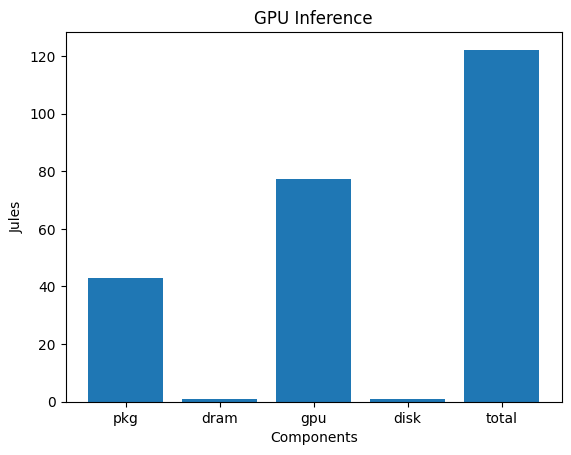

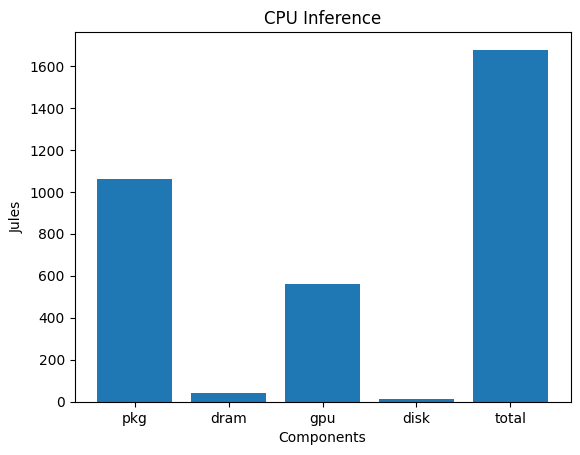

In [22]:
meter_gpu.plot_total_jules_per_component("meter_2023-06-19 12:43:24")
meter_cpu.plot_total_jules_per_component("meter_2023-06-19 12:43:24")